In [1]:
import torch
from transformers import CamembertTokenizer, CamembertModel, CamembertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np
from confmat import plot_confusion_matrix

### Charger un modèle Camembert pré-entrainé 

On utilise la classe CamembertForSequenceClassification afin de l'utiliser pour de la classification

On charge également le tokenizer

In [2]:
model_dir = "models/tweetbert"

In [3]:
tokenizer = CamembertTokenizer.from_pretrained(model_dir, do_lowercase=False)
classifier = CamembertForSequenceClassification.from_pretrained(model_dir)

Some weights of the model checkpoint at models/tweetbert were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at models/tweetbert and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight

### Charger les données

In [4]:
data_hate = pd.read_pickle("data_hate.pkl")

In [5]:
tweets = list(data_hate['tweet'])
labels = list(data_hate['sentiment'])

### Séparation jeu d'entraînement / jeu de test

In [6]:
train_tweets, test_tweets, train_labels, test_labels = train_test_split(tweets, labels, test_size=0.2, random_state=0)

### Préparation des jeux de données 

- Tokenisation.
- Création d'une classe héritant de Dataset pour recueillir le jeu de données. Cette classe doit implémenter deux méthodes :
  - Une méthode prenant un indice en argument et renvoyant l'entrée correspondante sous forme d'un dictionnaire.
  - une méthode renvoyant la taille du jeu de données
- Deux instanciation de cette classe pour le jeu d'entraînement et de test.

In [12]:
train_encodings = tokenizer(train_tweets, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_tweets, padding=True, truncation=True, max_length=512, return_tensors="pt")

In [13]:
class FrTwitterHateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def get_labels(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = FrTwitterHateDataset(train_encodings, train_labels)
test_dataset = FrTwitterHateDataset(test_encodings, test_labels)

### Dataloader pour équilibrer le dataset

In [15]:
from torchsampler import ImbalancedDatasetSampler

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    sampler=ImbalancedDatasetSampler(train_dataset),
    batch_size=16
)

### Optimiseur

In [16]:
optim = torch.optim.AdamW(classifier.parameters(), lr=5e-5)

### Charger le modèle dans la mémoire de la carte graphique

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
r = classifier.to(device)

### Boucle d'entraînement

In [18]:
%%time
for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = classifier(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

/tmp/ipykernel_14886/980926002.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


CPU times: user 2min 45s, sys: 1min 15s, total: 4min
Wall time: 4min 1s


### Prédiction sur le jeu de test

In [20]:
%%time
test_pred = []
for n in range(0, len(test_tweets), 10):
    phrases = test_tweets[n:n+10]
    enc = tokenizer(phrases, padding=True, truncation=True, max_length=512, return_tensors='pt')
    enc.to('cuda:0')
    with torch.no_grad():
        outp = classifier(**enc)
    pred = torch.nn.functional.softmax(outp.logits, dim=1)
    labels = torch.argmax(pred, dim=1)
    test_pred.append(labels)

CPU times: user 4.03 s, sys: 0 ns, total: 4.03 s
Wall time: 4.03 s


In [21]:
cat_pred = torch.cat(test_pred)

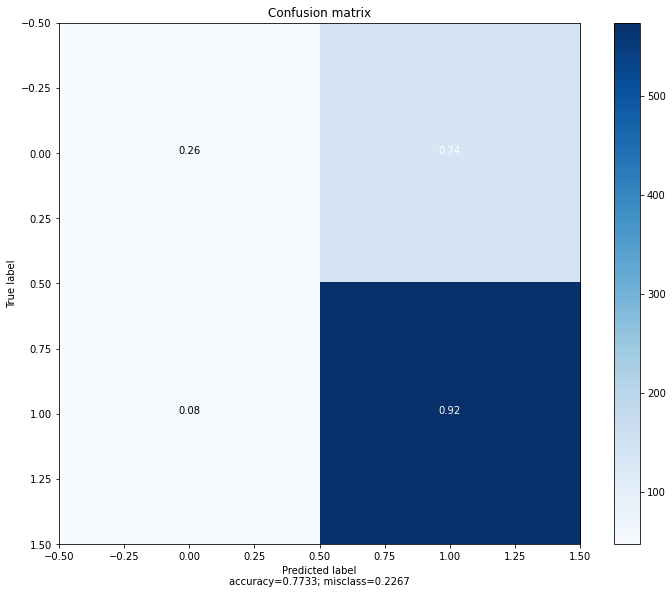

In [22]:
plot_confusion_matrix(test_labels, cat_pred.cpu(), None)

In [59]:
classifier.save_pretrained("models/bertweet_FT_IDS")